# Библиотеки и исходные данные

In [100]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

from sklearn.preprocessing import PolynomialFeatures

data = pd.read_csv('train.csv')
display(data.head())
display(data.info())

#test = pd.read_csv('test.csv')
#display(test.head())
#display(test.info())

#s_s = pd.read_csv('sample_submission.csv')
#display(s_s.head())
#display(s_s.info())

display(data.education.value_counts())
data['education'] = data.education.fillna(value='SCH') # заполнение пропусков
display(data.education.value_counts())

data['app_date'] = (pd.to_datetime(data['app_date'])-pd.to_datetime(0)).dt.days # преобразование формата даты

data['score_bki'] = -data['score_bki'] # замена отрицательных значений на положительные
display(data.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

None

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

SCH    39167
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,16102,SCH,M,62,Y,Y,0,0,2.008753,1,50,1,2,18000,4,1,N,0
1,63161,16141,SCH,F,59,N,N,0,0,1.532276,3,50,2,3,19000,4,1,N,0
2,25887,16102,SCH,M,25,Y,N,2,0,1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,16093,SCH,F,53,N,N,0,0,2.057471,2,50,2,3,10000,1,3,N,0
4,101655,16178,GRD,M,48,N,N,0,1,1.244723,1,60,2,3,30000,1,4,Y,0


In [2]:
# Описание исходных данных
Name_col = { 'client_id': 'идентификатор клиента',
'app_date': 'дата подачи заявки',
'education': 'уровень образования',
'sex': 'пол заёмщика',
'age': 'возраст заёмщика',
'car': 'флаг наличия автомобиля',
'car_type': 'флаг автомобиля-иномарки',
'decline_app_cnt': 'количество отказанных прошлых заявок',
'good_work': 'флаг наличия «хорошей» работы',
'score_bki': 'скоринговый балл по данным из БКИ',
'bki_request_cnt': 'количество запросов в БКИ',
'region_rating': 'рейтинг региона',
'home_address': 'категоризатор домашнего адреса',
'work_address': 'категоризатор рабочего адреса',
'income': 'доход заёмщика',
'sna': 'связь заемщика с клиентами банка',
'first_time': 'давность наличия информации о заемщике',
'foreign_passport': 'наличие загранпаспорта',
'default': 'наличие дефолта' }

# Функции

In [3]:
# функция для построения графиков группы переменных
def graf_gryp(data, Col_name, n, m, nn, mm, sh_st, ColoR, fl_stat, fl_log): 
    # data - массив данных; Col_name - колонки/переменные, для которых строится очередной график;
    # n, m - кол-во графиков в столбце, в строке; nn, mm - размеры графика; 
    # sh_st - толщина столбцов в столбцовой диаграмме; ColoR - цвет графика; 
    # fl_stat - флаг для вывода статистики; fl_log - флаг для логарифмирования значений переменной
    k1 = 0
    k2 = 0
    fig, axes = plt.subplots(n, m, figsize=(nn, mm))
    for i in Col_name:
        if fl_log==1:
            Col = np.log1p(data[i])
        else:
            Col = data[i]
        axes[k1, k2].hist(Col, color=str(ColoR), bins=sh_st)
        axes[k1, k2].set_title(Name_col[i])
        axes[n-1, k2].set_xlabel('Значения')
        axes[k1, 0].set_ylabel('Кол-во')
        if k2 > m-2:
            k1 += 1
            k2 = 0
        else:
            k2 += 1
        if fl_stat==1:
            print(Name_col[i],Col.describe(),end='\n\n')

# функция для построения графиков друг за другом
def graf(data, Col_name, n, m, sh_st, fl_stat): 
    for i in Col_name:
        fig = plt.figure()
        axes = fig.add_axes([0, 0, n, m])
        axes.set_title(str(Name_col[i]))
        axes.set_xlabel('Значения')
        axes.set_ylabel('Кол-во')
        plt.hist(data[i],color='violet',bins=sh_st)
        if fl_stat==1:
            print(Name_col[i],data[i].describe(),end='\n\n')

# Осмотр данных

дата подачи заявки count    73799.000000
mean     16132.035434
std         32.121884
min      16071.000000
25%      16104.000000
50%      16133.000000
75%      16160.000000
max      16190.000000
Name: app_date, dtype: float64

идентификатор клиента count     73799.000000
mean      55137.965094
std       31841.921168
min           1.000000
25%       27440.500000
50%       55274.000000
75%       82758.500000
max      110147.000000
Name: client_id, dtype: float64

возраст заёмщика count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64

количество отказанных прошлых заявок count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64

скоринговый балл по данным из БКИ count    73799.000000
mean  

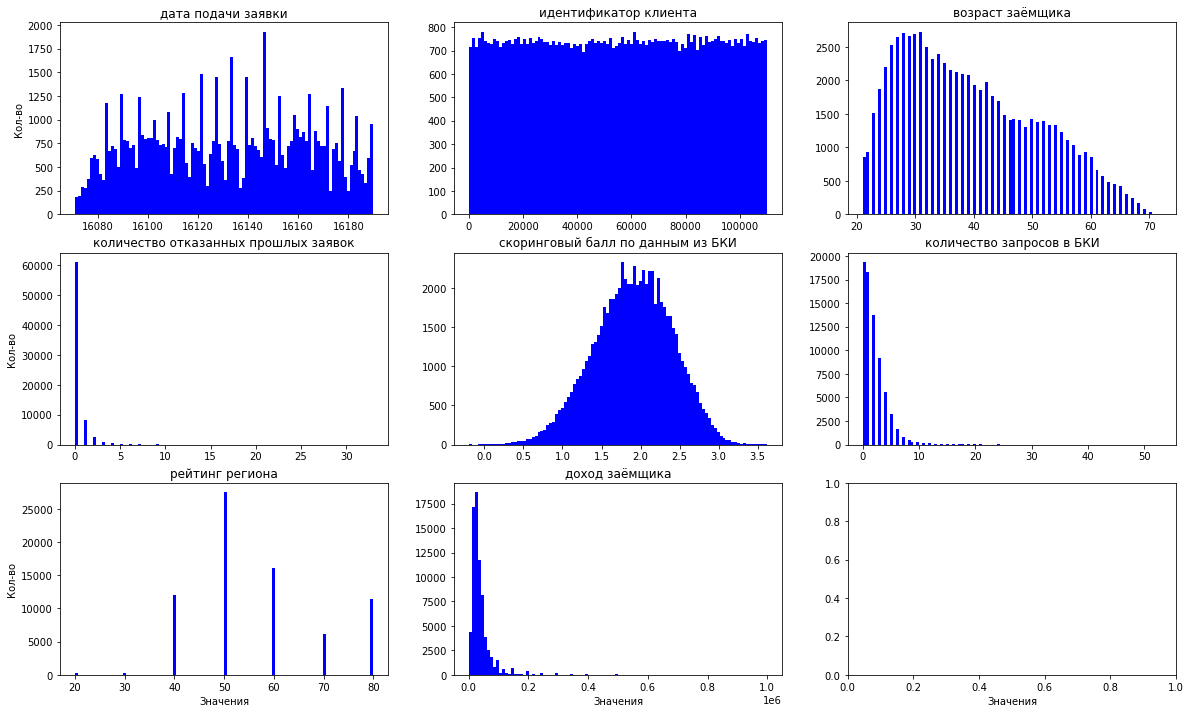

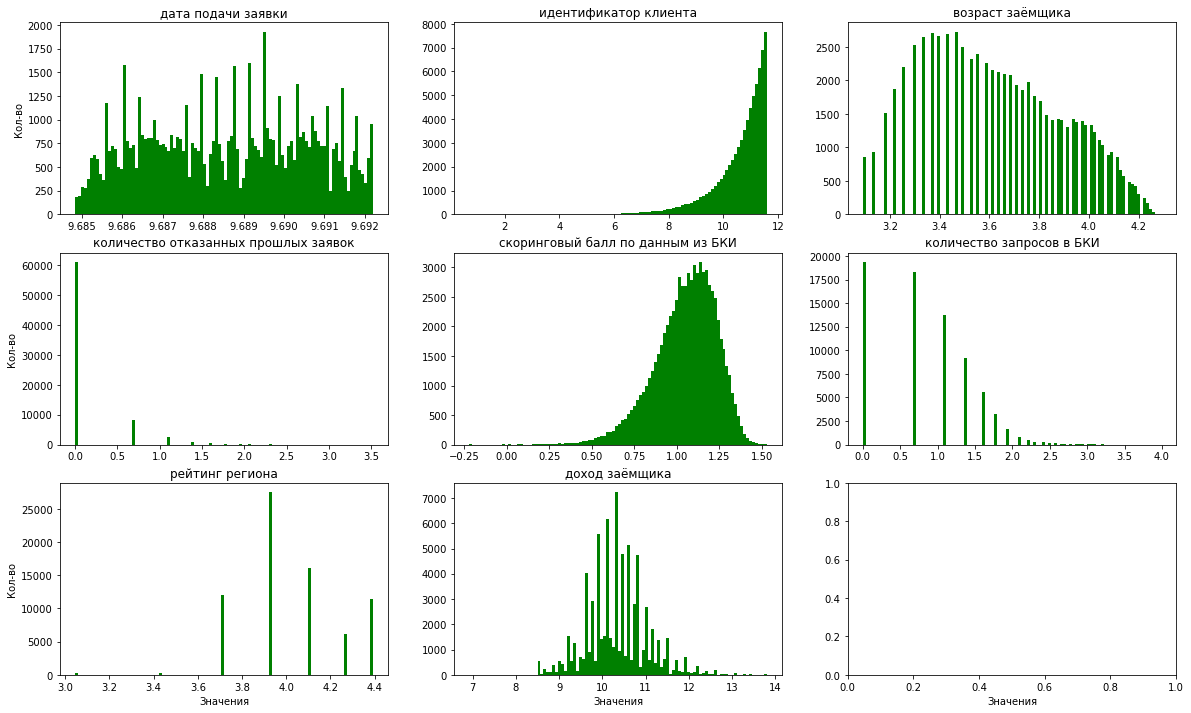

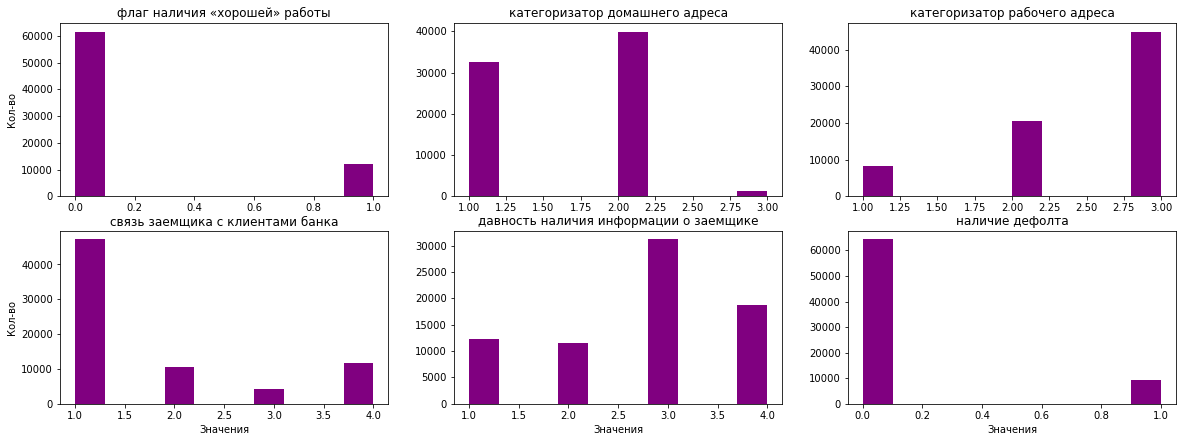

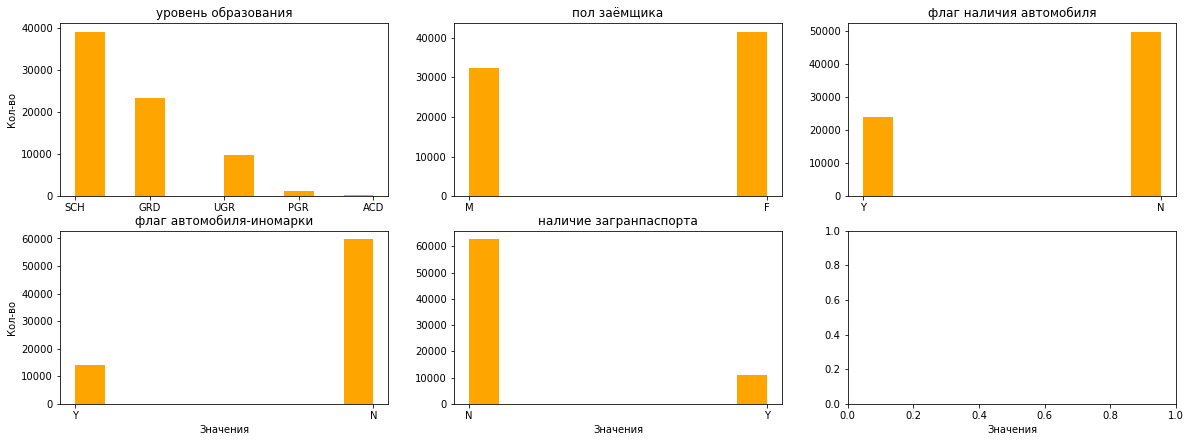

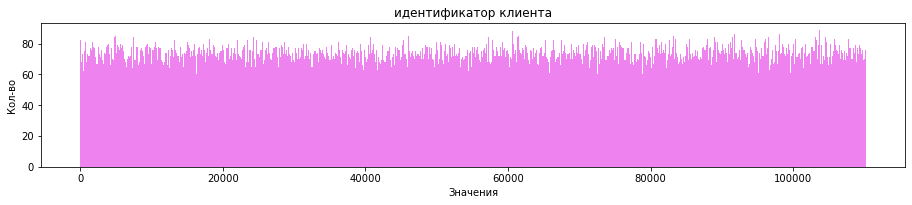

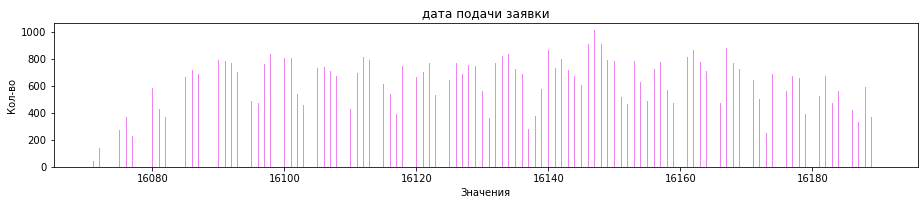

In [4]:
Col_Num = ['app_date', 'client_id', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']
Col_Num_diskr = ['good_work', 'home_address', 'work_address', 'sna', 'first_time', 'default']
Col_Nom = ['education', 'sex', 'car', 'car_type', 'foreign_passport']
Col_Data_ID = ['client_id', 'app_date']

graf_gryp(data,Col_Num,3,3,20,12,100,'blue',1,0)
graf_gryp(data,Col_Num,3,3,20,12,100,'green',0,1)
graf_gryp(data,Col_Num_diskr,2,3,20,7,10,'purple',0,0)
graf_gryp(data,Col_Nom,2,3,20,7,10,'orange',0,0)

graf(data,Col_Data_ID,2,0.5,1000,0)

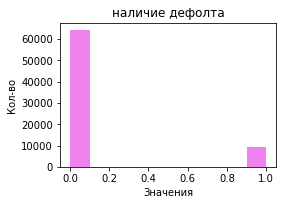

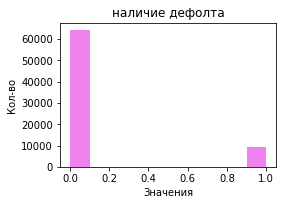

In [101]:
# Формирование более сбалансированной выборки
Col_def = ['default']
graf(data,Col_def,0.5,0.5,10,0)

data_DF = data[data.default==1]
data_DF_ = data[data.default==0]
data_DF_ = data_DF_.iloc[:data_DF.shape[0]]
fl_vb=0 # 0/1/2
# флаг fl_vb определяет способ формирования выборки для обучения:
# 0 - использование заданной выборки (не сбалансированной); 
# 1 - формирование более сбалансированной выборки путём клонирования данных с default==1;
# 2 - формирование более сбалансированной выборки путём удаления данных с default==0
if fl_vb==1:
    data=pd.concat([data, data_DF, data_DF, data_DF, data_DF, data_DF, data_DF])
elif fl_vb==2:
    data=pd.concat([data_DF, data_DF_])
graf(data,Col_def,0.5,0.5,10,0)
# балансирование выборки способами 1/2 не привело к существенному повышению точности

# Анализ численных переменных

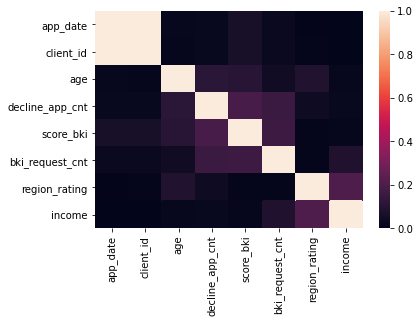

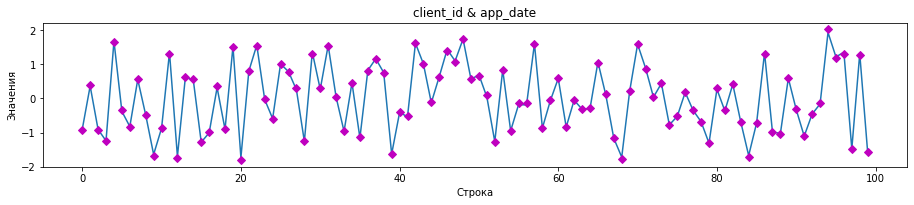

In [102]:
# Анализ корреляции
sns.heatmap(data[Col_Num].corr().abs(), vmin=0, vmax=1)

# Наглядное подтверждение полного соответствия значений колонок 'client_id' & 'app_date'
data_ = data.iloc[:100]
fig = plt.figure()
axes = fig.add_axes([0,0,2,0.5])
axes.set_title('client_id & app_date')
axes.set_xlabel('Строка')
axes.set_ylabel('Значения')
axes.plot((data_['client_id']-data_['client_id'].mean())/data_['client_id'].std())
axes.plot((data_['app_date']-data_['app_date'].mean())/data_['app_date'].std(), 'mD')

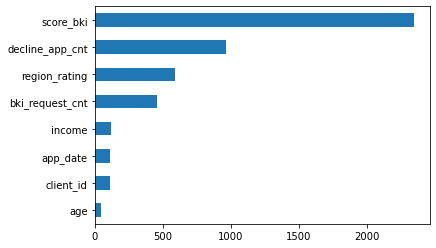

In [103]:
# Важность признаков для модели
imp_num = Series(f_classif(data[Col_Num], data['default'])[0], index = Col_Num)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Анализ категориальных переменных

In [104]:
# Замена категорий численными значаниями
label_encoder = LabelEncoder()

for column in Col_Nom:
    data[column] = label_encoder.fit_transform(data[column])   
display(data.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,16102,3,1,62,1,1,0,0,2.008753,1,50,1,2,18000,4,1,0,0
1,63161,16141,3,0,59,0,0,0,0,1.532276,3,50,2,3,19000,4,1,0,0
2,25887,16102,3,1,25,1,0,2,0,1.408142,1,80,1,2,30000,1,4,1,0
3,16222,16093,3,0,53,0,0,0,0,2.057471,2,50,2,3,10000,1,3,0,0
4,101655,16178,1,1,48,0,0,0,1,1.244723,1,60,2,3,30000,1,4,1,0


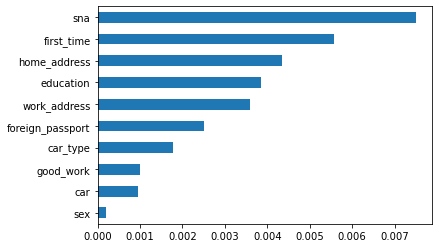

In [105]:
# Важность признаков для модели
imp_cat = Series(mutual_info_classif(data[Col_Nom+Col_Num_diskr[:-1]], data['default'],
                                     discrete_features =True), index = Col_Nom+Col_Num_diskr[:-1])
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Подготовка данных к обучению

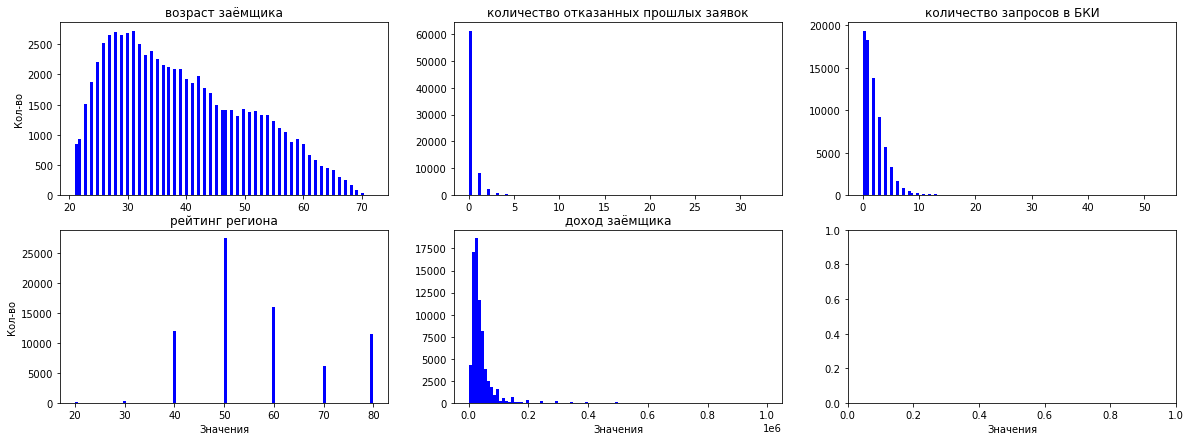

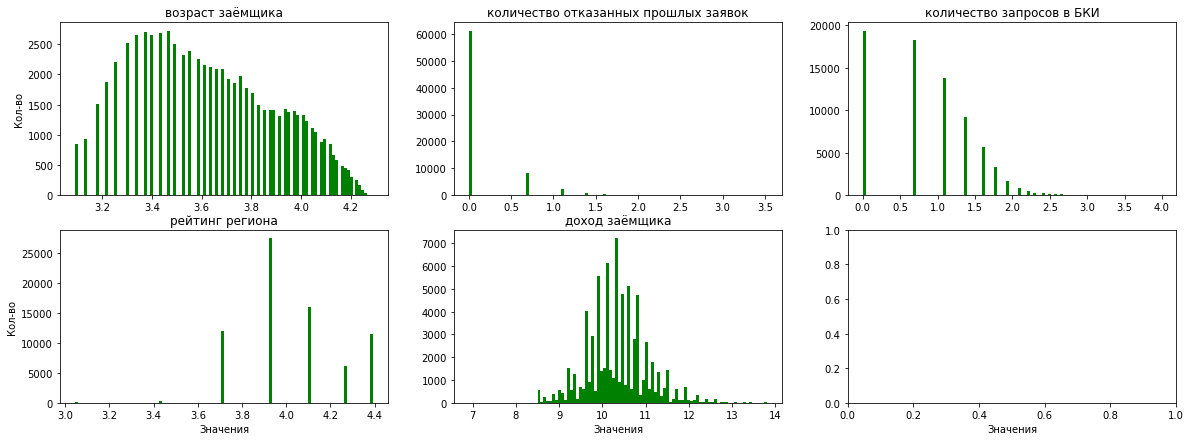

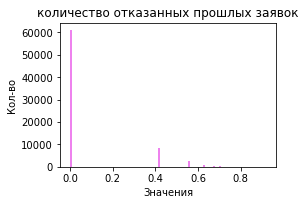

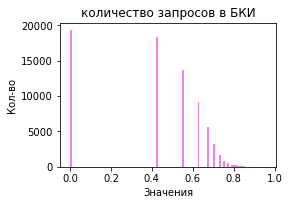

In [106]:
# Логарифмирование некоторых переменных
Col_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'region_rating', 'income']
graf_gryp(data,Col_log,2,3,20,7,100,'blue',0,0)
for i in Col_log:
    data[i]=np.log1p(data[i])
graf_gryp(data,Col_log,2,3,20,7,100,'green',0,0)
Col_log = ['decline_app_cnt', 'bki_request_cnt']
for i in Col_log:
    data[i]=np.log1p(np.log1p(data[i]))
graf(data,Col_log,0.5,0.5,100,0)
# логарифмирование применяется с целью получения более равномерного распределения признаков и уменьшения влияния выбросов 

In [107]:
# Создание полиномиальных признаков
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(data[['age', 'region_rating']])
print(poly_features)
print(poly_features[:,3:])
# из комбинации различных вариантов признаков 'app_date', 'client_id', 'age', 'decline_app_cnt', 
# 'score_bki', 'bki_request_cnt', 'region_rating', 'income' выбрана пара 'age' - 'region_rating'
# как больше всего влияющая на повышение точности 

[[ 1.          4.14313473  3.93182563 17.16556536 16.29008332 15.45925281]
 [ 1.          4.09434456  3.93182563 16.76365739 16.0982489  15.45925281]
 [ 1.          3.25809654  4.39444915 10.61519305 14.31753958 19.31118337]
 ...
 [ 1.          3.4657359   4.39444915 12.01132535 15.23000021 19.31118337]
 [ 1.          3.40119738  3.93182563 11.56814363 13.37291505 15.45925281]
 [ 1.          3.55534806  3.93182563 12.64049984 13.97900864 15.45925281]]
[[17.16556536 16.29008332 15.45925281]
 [16.76365739 16.0982489  15.45925281]
 [10.61519305 14.31753958 19.31118337]
 ...
 [12.01132535 15.23000021 19.31118337]
 [11.56814363 13.37291505 15.45925281]
 [12.64049984 13.97900864 15.45925281]]


In [108]:
# Формирование набора признаков для обучения
# флаг fl_r 1 - использование всех признаков с разбиением категорий на столбцы;
# 2 - использование параметров, более всего влияющих на результат с разбиением категорий на столбцы;
# 3 - использование всех признаков без разбиения категорий на столбцы
fl_r=1 # 1/2/3
if fl_r==1:
    # Разбиение категорий на столбцы
    X_cat = OneHotEncoder(sparse = False).fit_transform(data[Col_Nom[:1]+Col_Num_diskr[1:-1]].values)
    print(X_cat.shape)

    # Стандартизация числовых переменных
    X_num = StandardScaler().fit_transform(data[Col_Num[1:]].values) # [1:]

    # Объединение
    X = np.hstack([X_num, data[Col_Nom[1:]+Col_Num_diskr[:1]].values, X_cat, poly_features[:,3:]])
elif fl_r==2: 
    # анологично, Разбиение, Стандартизация, Объединение
    X_cat = OneHotEncoder(sparse = False).fit_transform(data[['sna', 'home_address' 
                                                         ]].values) # 'education', 'work_address', 'first_time'
    X_num = StandardScaler().fit_transform(data[['decline_app_cnt', 'score_bki', 'region_rating']].values) # 'bki_request_cnt'
    X = np.hstack([X_num, X_cat])
elif fl_r==3:
    # Стандартизация, Объединение
    X_cat = StandardScaler().fit_transform(data[Col_Nom[:1]+Col_Num_diskr[1:-1]].values)
    X_num = StandardScaler().fit_transform(data[Col_Num[1:]].values)
    X = np.hstack([X_num, data[Col_Nom[1:]+Col_Num_diskr[:1]].values, X_cat, poly_features[:,3:]])
    
print(X[0])

Y = data['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)
print(X_train.shape, X_test.shape)
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

(73799, 19)
[-0.91807159  1.71113664 -0.44410574  0.2087987   0.03678995 -0.43806048
 -0.78501579  1.          1.          1.          0.          0.
  0.          0.          0.          1.          0.          1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          1.          0.          0.
  0.         17.16556536 16.29008332 15.45925281]
(59039, 34) (14760, 34)
Количество строк в y_train по классам: [51541  7498]
Количество строк в y_test по классам: [12886  1874]


# Обучение

In [109]:
model = LogisticRegression(penalty='l2', C=1, max_iter=500) # penalty='l2', C=0.78
model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=500)

# Анализ результатов

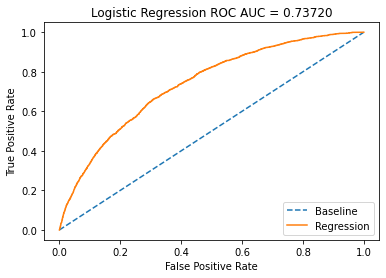

In [110]:
# ROC-анализ
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
# модель работает лучше чем случайное угадывание

Confusion matrix:
[[12816  1811]
 [   70    63]]


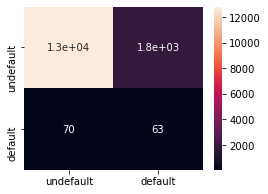

In [111]:
# анализ confusion matrix
Y_predicted = model.predict(X_test)
conf_mat = confusion_matrix(y_test,Y_predicted).T
print('Confusion matrix:\n{}'.format(conf_mat))

class_names = ['undefault', 'default']
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True)
# при fl_vb==2 погрешность определения undefault ~ 34%, default ~ 34%
# при fl_vb==1 погрешность определения undefault ~ 33%, default ~ 33%
# при fl_vb==0 погрешность определения undefault ~ 12%, default ~ 53%, 
# при использовании несбалансированной выборка модель необоснованно "доверят клиенту"

In [112]:
# исследование влияния параметра l2 на модель
F1_l2=[]
RA_l2=[]
l2=np.arange(0.02,1.02,0.02)
for i in range(l2.shape[0]):
    model = LogisticRegression(penalty='l2', C=l2[i], max_iter=1500) # обучаем модель
    model.fit(X_train, y_train)

    Y_predicted = model.predict(X_test)
    F1_l2.append(f1_score(y_test,Y_predicted))
    
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    RA_l2.append(roc_auc_score(y_test, probs))

F1 = 0.06371329019412643 l2 = 0.86


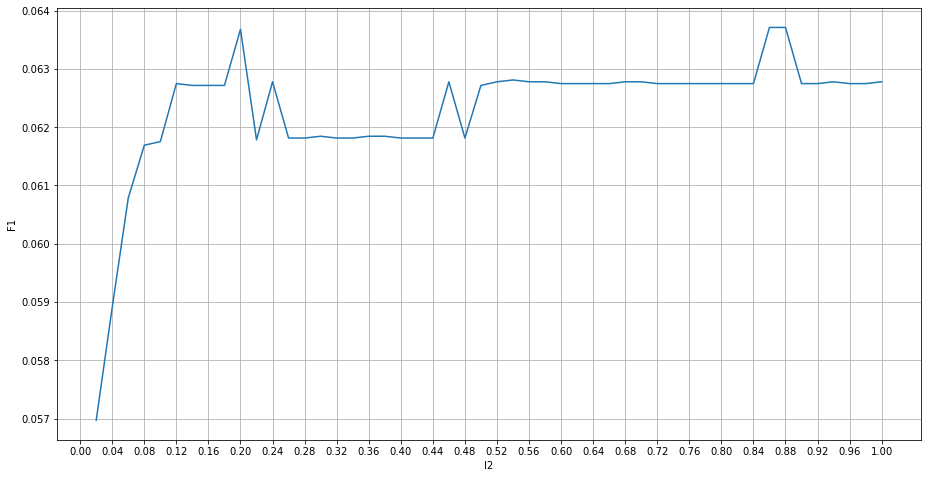

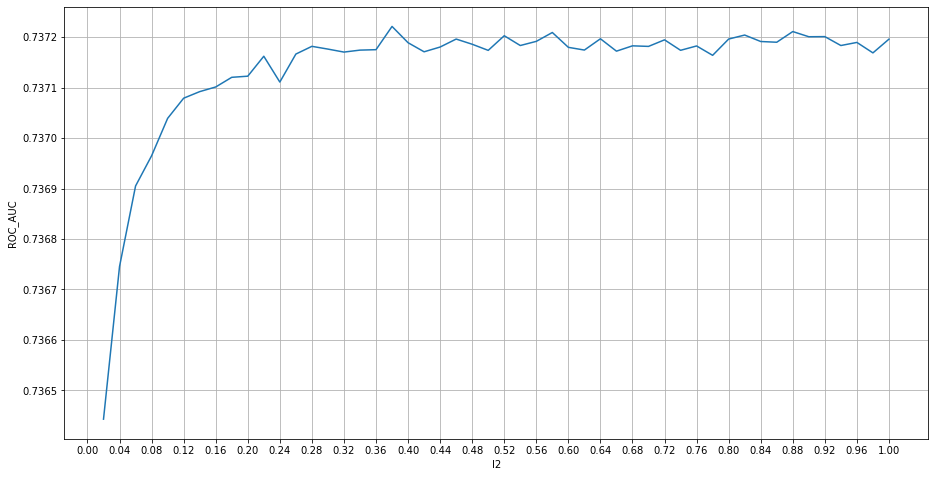

In [113]:
# визуализация влияния параметра l2 на модель, зависимости F1(l2), ROC_AUC(l2)
#print(l2)
#print(F1_l2)
value = max(F1_l2)
index = np.argmax(F1_l2)
print('F1 =',value, 'l2 =', l2[index]) # значение l2 для максимального F1

fig = plt.figure()
axes = fig.add_axes([0,0,2,1.5])
axes.grid()
axes.set_xlabel('l2')
axes.set_ylabel('F1')
axes.set_xticks(np.arange(0, 1.02, 0.04))
#axes.set_ylim([0,1])
axes.plot(l2, F1_l2)

fig = plt.figure()
axes = fig.add_axes([0,0,2,1.5])
axes.grid()
axes.set_xlabel('l2')
axes.set_ylabel('ROC_AUC')
axes.set_xticks(np.arange(0, 1.02, 0.04))
#axes.set_ylim([0,1])
axes.plot(l2, RA_l2)
# при fl_vb==1/2 (сбалансированная выборка) метрики ROC_AUC и F1 показывают сходные значения, 
# что соответствует качеству работы модели
# при fl_vb==0 (несбалансированная выборка) при достаточно высоком значении метрики ROC_AUC
# можно видеть довольно низкий показатель F1, что говорить о низкой точности модели 
# confusion matrix лучше всего показывает суть проблеммы - модель предпочтиает предсказывать 
# undefault, т.к. таких людей подавляющее большенство